# Solutions (SHVQE + readout error mitigation)

In [8]:
import warnings
# warnings.filterwarnings('ignore')
import time
import pickle

import numpy as np
import pandas as pd

from qiskit import *
import qiskit
from qiskit.tools.jupyter import *
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.fake_provider import *
from qiskit.utils import algorithm_globals
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, Aer
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

import stim

In [9]:
seeds = 170
algorithm_globals.random_seed = seeds
seed_transpiler = seeds
shot = int(np.floor(1800000 / 631))
# shot = 10

In [10]:
shot

2852

The total number of shots:

In [11]:
shot * 631

1799612

## Preprossing: Clifford Hamiltonian conversion

By using SHVQE, we need to apply the inversal of Heisenberg part to the original Hamiltonian. First, load the original Hamiltonian from `Hamiltonian/OHhamiltonian.txt`.

In [12]:
with open('Hamiltonian/OHhamiltonian.txt', 'r') as file:
    pauli_text_lines = file.readlines()
paulis = []
weight = []
for line in pauli_text_lines:
    line = line.replace(' ', '')
    coeff, pauli_text_string = line.split("*")
    coeff = float(coeff)
    weight.append(coeff)
    # pauli_text_string = pauli_text_string[::-1] # TODO: this is a quick but wrong fix for qubits order
    pauli_text_string = pauli_text_string.replace('\n', '')
    paulis.append(pauli_text_string)

Then, we use `Stim` to apply the inversal of Heisenberg part to Hamiltonian. In our protocal, the Heisenberg part consists of `cz` gates, which commute with each other. The inversal of the Heisenberg part is itself.

In [13]:
heisenberg_text_combined = ''

with open('saved_models/shvqe_clifford_ncz0_hei.qasm', 'r') as file:
    heisenberg_text_lines = file.readlines()
    heisenberg_text_combined = ''.join(heisenberg_text_lines[3:]) # omit the header

In [14]:
import re


# Define the regular expression pattern
pattern = r"q\[(\d+)\],q\[(\d+)\]"

# Define the replacement string
replacement = r"\1 \2"

# Use the sub() function to replace the matches
stim_text = re.sub(pattern, replacement, heisenberg_text_combined).replace(';', '')

Apply the Heisenberg circuit to each Pauli string. For any scale of quantum devices, classical simulation of Clifford circuits is efficient due to the Gottesman–Knill theorem.

In [16]:
%%time

heisenberg_circ = stim.Circuit(stim_text)
paulis_new = []

for p in paulis:
    ps  = stim.PauliString(p.replace('I', '_'))
    ps = ps.after(heisenberg_circ)
    paulis_new.append(ps.__str__().replace('_', 'I'))

CPU times: user 21.4 ms, sys: 0 ns, total: 21.4 ms
Wall time: 21.1 ms


Construct the new Hamiltonian as observable. The number of Pauli strings is not changed by Clifford.

In [17]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(paulis_new, weight)
print(f">>> Observable size: {observable.size}")

>>> Observable size: 631


## Circuit Transpile and Execution

To implement readout error mitigation, we hack into the `Estimator` class provided by `qiskit`. The source code can be found as `estimator_rem.py`.

In [18]:
from qiskit import qasm2

# our implementation of Estimator with REM
from estimator_rem import EstimatorRem

# the original implementation of Estimator
from qiskit_aer.primitives import Estimator

circuit = qasm2.load('saved_models/shvqe_clifford_ncz0_sch.qasm')

We load the circuits and reverse its qubits to respect qiskit convention. The circuit we use consists of only single-qubit rotations. Because the entanglement is virtually created by Clifford Heisenberg circuits in SHVQE.

In [19]:
circuit = circuit.reverse_bits()

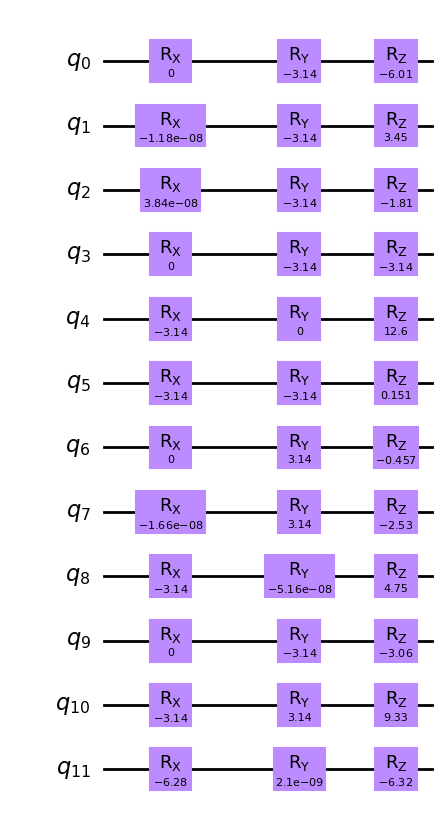

In [21]:
circuit.draw('mpl')

Transpile the circuit based on given system model from IBMQ_Montreal. **We use default transpiler from qiskit.**

In [22]:
system_model = FakeMontreal()

In [23]:
transpiled_circuit = transpile(circuit, backend=system_model)

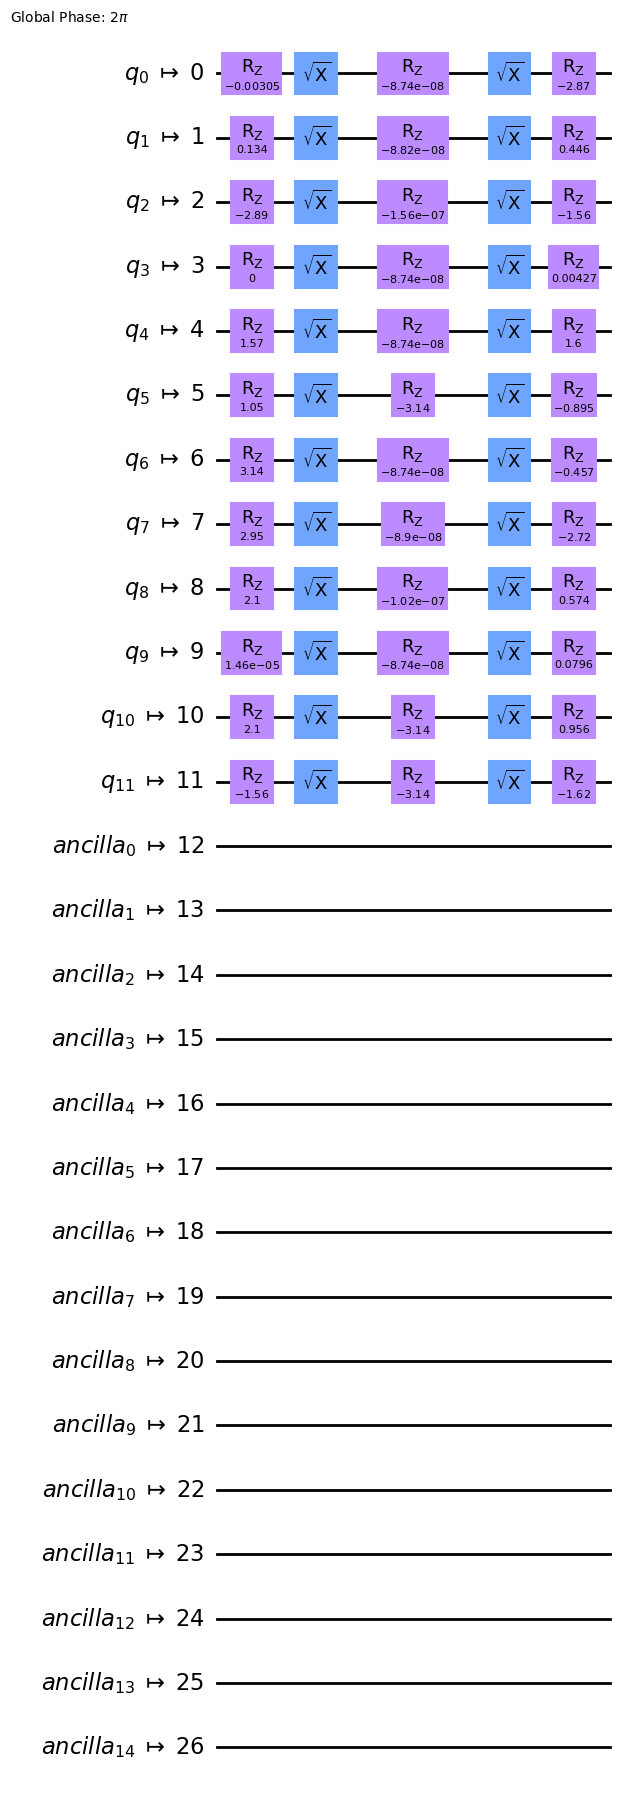

In [26]:
transpiled_circuit.draw('mpl')

### Noiseless

Evaluate on the qiskit Estimator. Consider noiseless first.

In [27]:
def get_error_rate(val):
    ref_value = -74.38714627
    nuclear_repulsion_energy = 4.365374966545
    energy_with_nuclear_repulsion = val + nuclear_repulsion_energy
    error_rate = abs(abs(ref_value - energy_with_nuclear_repulsion) / ref_value * 100)
    return error_rate

In [28]:
estimator_noiseless = Estimator(
    backend_options = {
        # simulation options, use multiple cpus
        'method': 'statevector',
        'device': 'CPU',
        'max_parallel_threads' : 0,
        'max_parallel_shots' : 0,
        'statevector_parallel_threshold' : 5,
        'coupling_map' : system_model.configuration().coupling_map,
        'noise_model': None # noiseless
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    transpile_options = {
        'seed_transpiler' : seed_transpiler,
    },
    skip_transpilation=False,
    
)

In [29]:
%%time
job_noiseless = estimator_noiseless.run(circuit, observable)
result_noiseless = job_noiseless.result()
print('Energy:', result_noiseless.values)

Energy: [-78.67793043]
CPU times: user 1h 48min 59s, sys: 17 s, total: 1h 49min 16s
Wall time: 1min 19s


In [30]:
print('Energy error:', get_error_rate(result_noiseless.values)[0])

Energy error: 0.10027378508814073


### Noisy

For readout error mitigation, we first load the readout error process matrices of noise models.

In [36]:
noise_model_name = ['fakecairo', 'fakekolkata', 'fakemontreal']
measure_noise_matrix = {}
representations = {}
for noise_name in noise_model_name:
    measure_noise_matrix[noise_name] = []
    noise_dict = pd.read_pickle('./NoiseModel/'+noise_name+'.pkl')
    single_qubit_noise_operator = []

    for qubit in range(27):
        single_qubit_noise_operator.append([])
        
    for noise_subdict in noise_dict['errors']:
        if len(noise_subdict['gate_qubits'][0])==1:
            qubit = noise_subdict['gate_qubits'][0][0]
            single_qubit_noise_operator[qubit].append(noise_subdict)
    single_noisy_super_op_list = []
    for qubit in range(27):
        single_noisy_super_op_list.append([])

        for noisy_operator in single_qubit_noise_operator[qubit]:
            if noisy_operator['operations'][0]=='measure':
                measure_noise_matrix[noise_name].append(np.array(noisy_operator['probabilities']).T)

#### Fake Kolkata

In [16]:
import pickle

In [38]:
def get_noise_matrix_inv(readout_noise_matrix, qubits):
    readout_noise_matrix_inv = []
    for i in qubits:
        matrix = readout_noise_matrix[i]
        readout_noise_matrix_inv.append(np.linalg.inv(matrix))
    return readout_noise_matrix_inv

In [39]:
readout_noise_matrix_fakekolkata = get_noise_matrix_inv(measure_noise_matrix['fakekolkata'], range(12))

In [41]:
with open('NoiseModel/fakekolkata.pkl', 'rb') as file:
    noise_model_fakekolkata = noise.NoiseModel.from_dict(pickle.load(file))

/tmp/ipykernel_67897/3864961774.py:2: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  noise_model_fakekolkata = noise.NoiseModel.from_dict(pickle.load(file))


In [43]:
estimator_fakekolkata = EstimatorRem(
    backend_options = {
        # simulation options
        'method': 'statevector',
        'device': 'CPU',
        'max_parallel_threads' : 0,
        'max_parallel_shots' : 0,
        'statevector_parallel_threshold' : 5,
        'coupling_map' : system_model.configuration().coupling_map,
        'noise_model': noise_model_fakekolkata,
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    transpile_options = {
        'seed_transpiler' : seed_transpiler,
    },
    skip_transpilation=False,
    measurement_noise_matrix_inv = readout_noise_matrix_fakekolkata
)

In [44]:
%%time

job_fakekolkata = estimator_fakekolkata.run(circuit, observable)
result_fakekolkata = job_fakekolkata.result()

result_fakekolkata.values[0]

CPU times: user 1h 5min 4s, sys: 18min 22s, total: 1h 23min 27s
Wall time: 2min 26s


-78.68981691925806

In [45]:
get_error_rate(result_fakekolkata.values)[0]

0.08429455951885581

#### Fake Cairo

In [51]:
with open('NoiseModel/fakecairo.pkl', 'rb') as file:
    noise_model_fakecairo = noise.NoiseModel.from_dict(pickle.load(file))

/tmp/ipykernel_67897/1409486957.py:2: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  noise_model_fakecairo = noise.NoiseModel.from_dict(pickle.load(file))


In [47]:
readout_noise_matrix_fakecairo = get_noise_matrix_inv(measure_noise_matrix['fakecairo'], range(12))

In [48]:
estimator_fakecairo = EstimatorRem(
    backend_options = {
        # simulation options
        'method': 'statevector',
        'device': 'CPU',
        'max_parallel_threads' : 0,
        'max_parallel_shots' : 0,
        'statevector_parallel_threshold' : 5,
        'coupling_map' : system_model.configuration().coupling_map,
        'noise_model': noise_model_fakecairo,
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    transpile_options = {
        'seed_transpiler' : seed_transpiler,
    },
    skip_transpilation=False,
    measurement_noise_matrix_inv = readout_noise_matrix_fakecairo
)

In [49]:
%%time

job_fakecairo = estimator_fakecairo.run(circuit, observable)
result_fakecairo = job_fakecairo.result()
result_fakecairo.values[0]

CPU times: user 1h 6min 1s, sys: 18min 16s, total: 1h 24min 18s
Wall time: 2min 26s


-78.69202675045504

In [50]:
get_error_rate(result_fakecairo.values)[0]

0.08132384306072264

### Fake Montreal

In [53]:
with open('NoiseModel/fakemontreal.pkl', 'rb') as file:
    noise_model_fakemontreal = noise.NoiseModel.from_dict(pickle.load(file))

/tmp/ipykernel_67897/3624331980.py:2: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  noise_model_fakemontreal = noise.NoiseModel.from_dict(pickle.load(file))


In [56]:
readout_noise_matrix_fakemontreal = get_noise_matrix_inv(measure_noise_matrix['fakemontreal'], range(12))

In [57]:
estimator_fakemontreal = EstimatorRem(
    backend_options = {
        # simulation options
        'method': 'statevector',
        'device': 'CPU',
        'max_parallel_threads' : 0,
        'max_parallel_shots' : 0,
        'statevector_parallel_threshold' : 5,
        'coupling_map' : system_model.configuration().coupling_map,
        'noise_model': noise_model_fakemontreal,
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    transpile_options = {
        'seed_transpiler' : seed_transpiler,
    },
    skip_transpilation=False,
    measurement_noise_matrix_inv = readout_noise_matrix_fakemontreal
)

In [58]:
%%time

job_fakemontreal = estimator_fakemontreal.run(circuit, observable)
result_fakemontreal = job_fakemontreal.result()
result_fakemontreal.values[0]

CPU times: user 1h 6min 5s, sys: 18min 17s, total: 1h 24min 23s
Wall time: 2min 29s


-78.68849846419418

In [59]:
get_error_rate(result_fakemontreal.values)[0]

0.08606698275323509

## Duration

Obtain the Duration of Quantum Circuit

In [60]:
from qiskit import pulse

Do remember to set the optimization_level to 0 if your circuit is already transpiled!!!

In [61]:
transpiled_circuit = transpile(circuit, backend=system_model)

with pulse.build(system_model) as program:
  with pulse.transpiler_settings(optimization_level=0):
    pulse.call(transpiled_circuit)

In [62]:
program.duration

320

In [64]:
with open('saved_models/shvqe_clifford_ncz0_sch_transpiled.qasm', 'w+') as file:
    file.write(transpiled_circuit.qasm())